In [2]:
import pandas as pd

In [66]:
#this class is merely for encapsulation.
#this is how data of the dataset is stores in the objects 
#of this class.
class DataSet:
    #name of the dataset
    def __init__(self, name):
        self.name = name
    
    def set_feature(self, features):
        self.features = features
    
    def set_classes(self, classes):
        self.classes = classes
    
    def get_classes(self):
        return self.classes
        
    def set_org_data(self, org_data):
        self.org_data = org_data
        
    def get_org_data(self):
        return self.org_data
    
    # not writing all getters, setters, because
    # they are not required in python (i didnt know that before)

In [67]:
#Class reads the data file and the names file
#to load inti dataset object
class Dataset_Reader:
    
    def __init__(self):
        self.Path = 'C:\\Users\\nitas\\Downloads\\Machine Learning 2024\\MLProject2\\'
    
    #read the data from data file and fill the Datset class object
    def read_data_file(self, ds):
        if(ds.name == 'forestfires'):
            df = pd.read_csv(self.Path+ds.name+'.data', delimiter=',')
        else:    
            df = pd.read_csv(self.Path+ds.name+'.data', delimiter=',', header=None)

        ds.set_org_data(df)
    
    
    #read name file, naming the features, just to fill
    #for results, not mendatory function
    def read_attributes(self, ds):
        
        start_string = 'Attribute Information'
        stop_string = 'Missing Attribute Values'
        isPrint = False
        
        #read section, where the file has information 
        #Attribute Information
        with open(Path+ds.name+'.names', 'r') as file:
            for line in file:
                if start_string in line:
                    isPrint = True
                    #continue
                    
                if stop_string in line:
                    isPrint = False
                    break
                        
                if isPrint:
                    print(line.strip())
                        

# Pre Processing Class: Demonstration of Ten Fold

In [109]:
#Pre Process Class, for data cleaning, 
#checking for any abnormalities, pre processes the data 
import numpy as np
from sklearn.preprocessing import MinMaxScaler

class PreProcess:
    
    def __init__(self, ds):
        
        #set other values of the Dataset object    
        self.set_Dataset_features(ds)
        
        #min max scaling for the regression datasets
        if(ds.type == 'Regression'):
            self.min_max_scaling(ds)
        #now first step is to do one-hot encoding
        self.one_hot_encoding(ds)
        #Now sort the data, if it is not sorted
        self.sort_data(ds)
        #After this step, we will use only sorted data
        self.missing_values(ds)
    
    
    #Min max scaling 
    def min_max_scaling(self, ds):
        scaler = MinMaxScaler()
        #print(ds.org_data.head())
        # Apply scaling only to numeric columns
        numeric_cols = ds.org_data.select_dtypes(include=['float64', 'int64']).columns
        #print(numeric_cols)
        ds.org_data[numeric_cols] = scaler.fit_transform(ds.org_data[numeric_cols]) 
        #print('After applying Min Max Scaling:' ,ds.org_data.head())
    
    
    #This function sets the no of features and class names
    #to the Dataset class object
    def set_Dataset_features(self, ds):
        #set class names
        last_column_unique = ds.org_data.iloc[:, -1].unique()
        ds.set_classes(last_column_unique)
        #print(ds.get_classes())
        
        #set no of features, because one column is classes
        ds.feature_count = ds.org_data.shape[1] -1
        #print(ds.feature_count)
    
                
    #splitting data into 10 parts, Here we will
    #implement stratified 10 folds
    def split_data_regression(self,ds):
        
        # first we need to make 10 datasets of consectutive points
        #print('\n Printing the results of 10 folds')
        datagroupSize = len(ds.sorted_data) // 10  
        print('Fold Size', datagroupSize)
        dataGroup = []
        
        #reusing this part from my first project
        for i in range(10):
            start = i * datagroupSize
            end = start + datagroupSize
            if i == 9:  
                dataGroup.append(ds.sorted_data.iloc[start:])
            else:
                dataGroup.append(ds.sorted_data.iloc[start:end])
        
        
        #once we have datasets of sorted data, now we will make folds
        #with one point from each fold.
        folds = [[] for _ in range(10)]
        
        max_group_size = max(len(group) for group in dataGroup)
        print('Max Fold Size: ',max_group_size)
        
        # For each index up to the maximum group size
        for i in range(max_group_size):
            # Loop over the 10 groups
            for j in range(10):
                #print('fold:', j, 'datagroup :' ,j, 'value',  dataGroup[j].iloc[i, -1])
                # Check if the current group has enough data for the current index
                if i < len(dataGroup[j]):  
                    # Append the i-th example from the j-th group into the j-th fold
                    folds[j].append(dataGroup[j].iloc[i])

                    
        #converting folds into Dataframes
        final_folds = folds = [pd.DataFrame(fold) for fold in folds]
        ds.ten_folds = final_folds
        
        #for i in range(10):
        #    print(f'Fold {i + 1}:')
        #    print(final_folds[i].tail())
        
        #print("Ten Fold Prints")
        #for i, fold in enumerate(final_folds):
        #    print(f'Fold {i+1} size: {len(fold)}')
        #    print(fold.iloc[:, -1].value_counts())
    
    
    #splitting data into 10 parts, Here we will
    #implement stratified 10 folds for classification
    def split_data_classification(self,ds):
        
        #In this we first need to split data accordign to classes
        #Since we want the ratio of classes to be same in each fold
        classwise_data = {}
        
        for cls in ds.classes:
            classwise_data[cls] = ds.sorted_data[ds.sorted_data.iloc[:, -1] == cls]
                    
        # Now we will be creating the folds containing data from 
        # each fold of class, making the ratio same with original data
        folds = [[] for _ in range(10)]
        
        for cls, cls_data in classwise_data.items():
            
            #first divide the classwise data into 10 parts.
            clsPartsforFolds = len(cls_data) //10
            clsPartsRemain = len(cls_data) % 10
            
            #print('Number of class data per fold',clsPartsforFolds)
            #print('Remaining data left in class',clsPartsRemain)
            #put these values in all folds
            start = 0
            for i in range(10):
                if clsPartsRemain != 0:
                    # Add 1 to handle remaining data
                    end = start + clsPartsforFolds + 1  
                    clsPartsRemain -= 1
                else:
                    end = start + clsPartsforFolds
            
                # Append class data slice to the respective fold
                folds[i].extend(cls_data.iloc[start:end].values.tolist())
                start = end
            
        
        #converting folds into Dataframes
        final_folds = [pd.DataFrame(fold, columns=ds.sorted_data.columns) for fold in folds]    
        ds.ten_folds = final_folds
        
        #This section is just to check if the fold created are in the same ratio
        #for i in range(10):
        #    print(f'Fold {i + 1}:')
        #    print(final_folds[i].tail())
        
        for i, fold in enumerate(final_folds):
            print(f'Fold {i+1} size: {len(fold)}')
            print(fold.iloc[:, -1].value_counts())
        
    
    #added the function to see, if we will need it for any dataset
    def one_hot_encoding(self, ds):
        #this has first coloumn of categorical data, F, M and I
        if(ds.name == 'abalone'):
            #save class column and drop it
            class_column = ds.org_data.iloc[:, -1]  
            ds.org_data = ds.org_data.drop(ds.org_data.columns[-1], axis=1)
            
            #perform one hot encoding    
            first_column_name = ds.org_data.columns[0]
            one_hot_encoded = pd.get_dummies(ds.org_data[first_column_name], prefix=first_column_name)
            ds.org_data = pd.concat([ds.org_data.drop(columns=[first_column_name]), one_hot_encoded], axis=1)
            #append the saved class column to the end again
            ds.org_data = pd.concat([ds.org_data, class_column], axis=1)
        
        #this dataset has first column of manufacturer, and second column of 
        #model name, which has unique values, so dropping it.
        if(ds.name == 'machine'):
            
            #here i am dropping the last colum, because class / result is 
            ds.org_data = ds.org_data.drop(ds.org_data.columns[-1], axis=1)
            #save the class column and then drop it   
            class_column = ds.org_data.iloc[:, -1]
            ds.org_data = ds.org_data.drop(ds.org_data.columns[-1], axis=1)
            
            #drop the second column, which is model number
            ds.org_data = ds.org_data.drop(ds.org_data.columns[1], axis=1)
            first_column_name = ds.org_data.columns[0]
            one_hot_encoded = pd.get_dummies(ds.org_data[first_column_name], prefix=first_column_name)
            ds.org_data = pd.concat([ds.org_data.drop(columns=[first_column_name]), one_hot_encoded], axis=1)
            
            #append the saved class column to the end again
            ds.org_data = pd.concat([ds.org_data, class_column], axis=1)
        
        #first column is months, second column is days
        if ds.name == 'forestfires':
            
            #tranform the last column to log 
            #*****This is still not helping, we might need normalization*****
            ds.org_data['area'] = np.log(ds.org_data['area'] +  1)
            
            
            #save the class column and then drop it, 
            class_column = ds.org_data.iloc[:, -1]
            ds.org_data = ds.org_data.drop(ds.org_data.columns[-1], axis=1)
            
            first_column_name = ds.org_data.columns[2]
            second_column_name = ds.org_data.columns[3]
            one_hot_encoded = pd.get_dummies(ds.org_data[[first_column_name, second_column_name]], 
                                             prefix=[first_column_name, second_column_name])
                                    
            ds.org_data = pd.concat([ds.org_data.drop(columns=[first_column_name, second_column_name]), 
                                     one_hot_encoded], axis=1)
            
            #append the saved class column to the end again
            ds.org_data = pd.concat([ds.org_data, class_column], axis=1)
        
        #print("One hot Encoding Step, Resulted data shown below")
        #print(ds.org_data.head())
        
    #First we need to sort the data, if not sorted according to the 
    #classes, if data is already sorted, then original values will remain
    #same without change
    def sort_data(self, ds):
        ds.sorted_data = ds.org_data.sort_values(by=ds.org_data.columns[-1])
        #and then reset the index
        ds.sorted_data = ds.sorted_data.reset_index(drop=True)
        
        
    # this function handles missing values, for this project
    # forest fires has no missing values
    # Abalone has no missing values
    # machine has no missing values
    # glass has no missing values
    # Soybean has no missing values
    # breastCancer has missing values
    def missing_values(self, ds):      
        # Check if any missing values exist, using '?' and null values
        ds.sorted_data.replace('?', np.nan, inplace=True)
        has_missing_values = ds.sorted_data.isnull().values.any()
        missing_values_count = ds.sorted_data.isnull().sum().sum()
        
        if (has_missing_values):
            print("This dataset has missing values")
            if missing_values_count > 1:
                # It has missing values  
                #print("This dataset has more missing values")
                rows_with_missing = dds.sorted_data[ds.sorted_data.isnull().any(axis=1)].index
                #print("Rows with missing values before filling:")
                #print(ds.ds.sorted_data.loc[rows_with_missing])
                
                if(ds.name == 'breast-cancer-wisconsin'):
                    #print("Inside the median if")
                    for column in ds.sorted_data.columns[:-1]:
                        median_value = ds.sorted_data[column].median()
                        # Filling the missing values
                        ds.sorted_data[column].fillna(median_value, inplace=True)
    
                #print("Rows with missing values after filling:")
                #print(ds.sorted_data.loc[rows_with_missing])
            else:
                ds.sorted_data.dropna(inplace=True)
                print("Dropped the row")

    #This one function will work for classification    
    def split_tuning_data_classification(self, ds):
        print('Spliting the data into tunning and remaining')
        # Backup sorted data
        ds.sorted_data_bk = ds.sorted_data.copy()
    
        # Initialize empty lists for tuning and remaining data
        tuning_data = []
        remaining_data = []

        # Separate the data into classes
        for cls in ds.classes:
            #print(cls)
            classwise_data = ds.sorted_data[ds.sorted_data.iloc[:, -1] == cls]

            # Shuffle the data
            classwise_data = classwise_data.sample(frac=1, random_state=42).reset_index(drop=True)
        
            # Extract 10% tuning set
            num_tuning_samples = max(1, int(len(classwise_data) * 0.1))  
            #print('number of samples from this class',num_tuning_samples )
        
            # Append tuning set and remaining data
            tuning_data.append(classwise_data.iloc[:num_tuning_samples])
            remaining_data.append(classwise_data.iloc[num_tuning_samples:])
    
        # Concatenate tuning and remaining data
        ds.tuning_data = pd.concat(tuning_data).reset_index(drop=True)
        ds.sorted_data = pd.concat(remaining_data).reset_index(drop=True)
        
        print('Length of tuning data:',len(ds.tuning_data) )
        print('Length of remaining data:',len(ds.sorted_data) )
        print('Length of original data:',len(ds.sorted_data_bk) )

        
    def split_tuning_data_regression(self, ds):
        # Backup sorted data
        
        print('\n Spliting the data into tunning and remaining')
        tuning_fraction = 0.1
        n_bins = 10
        ds.sorted_data_bk = ds.sorted_data.copy()

        # Bin the target variable into quantiles (or any number of bins)
        ds.sorted_data['bins'] = pd.qcut(ds.sorted_data.iloc[:, -1], q=n_bins, labels=False, duplicates='drop')

        # Initialize empty lists for tuning and remaining data
        tuning_data = []
        remaining_data = []

        # Separate the data into bins (which act as pseudo-classes for stratification)
        for bin_value in ds.sorted_data['bins'].unique():
            bin_data = ds.sorted_data[ds.sorted_data['bins'] == bin_value]

            # Shuffle the data
            bin_data = bin_data.sample(frac=1, random_state=42).reset_index(drop=True)

            # Extract the specified fraction (10% by default) for the tuning set
            num_tuning_samples = int(len(bin_data) * tuning_fraction)

            # Append tuning set and remaining data
            tuning_data.append(bin_data.iloc[:num_tuning_samples])
            remaining_data.append(bin_data.iloc[num_tuning_samples:])

        # Concatenate tuning and remaining data
        ds.tuning_data = pd.concat(tuning_data).reset_index(drop=True)
        ds.sorted_data = pd.concat(remaining_data).reset_index(drop=True)

        # Drop the 'bins' column, as it's not needed anymore
        ds.sorted_data.drop(columns=['bins'], inplace=True)
        ds.tuning_data.drop(columns=['bins'], inplace=True)

        # Check lengths
        print('Length of tuning data:', len(ds.tuning_data))
        print('Length of remaining data:', len(ds.sorted_data))
        print('Length of original data:', len(ds.sorted_data_bk))    
        
        
        

In [6]:
from collections import defaultdict,Counter
import numpy as np

class KNN_Classification:
    def __init__(self, k=5):
        self.k = k

    def train(self, ds):
        #all columns except for the last, of all rows
        self.train_features = ds.train_data.iloc[:, :-1]
        #only last column of all rows
        self.train_cls = ds.train_data.iloc[:, -1]
        
            
    #testign the model
    def test(self,ds):
        #all columns except for the last, of all rows
        self.test_features = ds.test_data.iloc[:, :-1]
        #only last column of all rows
        self.test_cls = ds.test_data.iloc[:, -1]
        test_results = []
        
        for test in self.test_features.values:
            #store the distance for this test set
            distances =[]
            
            #for this test row, calculate the distance with each train row
            for train in self.train_features.values:
                #euclidean distance 
                distance = np.linalg.norm(train - test)
                distances.append(distance)
                
            #print("Distances: " , distances)    
            # Find indices of the k nearest neighbors
            k_indices = np.argsort(distances)[:self.k]
            
            
            #print("Indexes of these distnces: " , k_indices)
            # According to indices get the class from train set 
            k_nearest_labels = [self.train_cls.iloc[i] for i in k_indices]
            
            
            #print("Labels : " , k_nearest_labels)
            # find the most common labels among the k neighbors
            # as asked for classification
            most_common = Counter(k_nearest_labels).most_common(1)
            
            #print("Most common label : " , most_common)
            # predicted label for this test row
            predicted_label = most_common[0][0]
            test_results.append(predicted_label)
        
        results_df = pd.DataFrame({
        'Actual Class': self.test_cls.tolist(),   
        'Predicted Class': test_results           
        })


        return results_df
    
    
    #first prepare the test and train data from folds
    #then call train and test 10 times, and 
    #take the average to prepare the results
    def mainFunction(self, ds):   
        #adding combined results for each fold
        combined_results = pd.DataFrame()
        #combined_results = pd.DataFrame()
        #rs = Results()
        eval_result_dic = {}
        no_folds = 10
        
        for i in range(10):
            # one fold for testing
            print(f'Fold: {i}')
            ds.test_data = ds.ten_folds[i]            
            # remaining 9 folds for training
            ds.train_data = pd.concat([ds.ten_folds[j] for j in range(10) if j != i])
            
            self.train(ds)
            results = self.test(ds)
            print(results)

            

        
    

# KNN Regression Class: Demonstrate one example and Average over 10 Folds

In [121]:
from collections import defaultdict,Counter
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

class KNN_Regression:
    def __init__(self, k=5):
        self.k = k

    def train(self, ds):
        # All columns except for the last, of all rows
        self.train_features = ds.train_data.iloc[:, :-1]
        # Only last column of all rows
        self.train_cls = ds.train_data.iloc[:, -1]

    def test(self, ds):
        # All columns except for the last, of all rows
        self.test_features = ds.test_data.iloc[:, :-1]
        # Only last column of all rows
        self.test_cls = ds.test_data.iloc[:, -1]
        test_results = []

        for test in self.test_features.values:
            # Calculate the distance from the test point to all training points
            distances = [np.linalg.norm(train - test) for train in self.train_features.values]

            # Find indices of the k nearest neighbors
            k_indices = np.argsort(distances)[:self.k]
            #print("Indexes of distnces: " , k_indices)
            
            # Get the k nearest neighbor values from the training labels
            k_nearest_values = np.array([self.train_cls.iloc[i] for i in k_indices])
            #print("Values of nearest neighbours: " , k_nearest_values)
            
            # Get the k nearest neighbor distances
            k_nearest_distances = np.array([distances[i] for i in k_indices])

            # Compute inverse distance weights for the k nearest neighbors
            # I started with basic mean, but then added this (weighted average)
            # afetr checking online this will give better results 
            weights = []
            for distance in k_nearest_distances:
                if distance == 0:
                    weights.append(1e10)  
                else:
                    weights.append(1 / distance)  

            weights = np.array(weights)

            # Calculate the weighted sum for the predicted value
            weighted_sum = np.dot(k_nearest_values, weights) / np.sum(weights)
            #print("Weighted average of these values : " , weighted_sum)
            
            # Store the predicted value
            test_results.append(weighted_sum)

        # Create a results DataFrame
        results_df = pd.DataFrame({
            'Actual Class': self.test_cls.tolist(),
            'Predicted Class': test_results
        })
        
        return results_df
    
    #This is just for the video
    def print_oneResult(self, ds):
        
        print('\n Printing the results of one data point')
        # All columns except for the last, of all rows
        self.test_features = ds.test_data.iloc[:, :-1]
        # Only last column of all rows
        self.test_cls = ds.test_data.iloc[:, -1]
        test_results = []

        for test in self.test_features.values:
            # Calculate the distance from the test point to all training points
            distances = [np.linalg.norm(train - test) for train in self.train_features.values]

            # Find indices of the k nearest neighbors
            k_indices = np.argsort(distances)[:self.k]
            print("Indexes of distnces: " , k_indices)
            
            # Get the k nearest neighbor values from the training labels
            k_nearest_values = np.array([self.train_cls.iloc[i] for i in k_indices])
            print("Values of nearest neighbours: " , k_nearest_values)
            
            # Get the k nearest neighbor distances
            k_nearest_distances = np.array([distances[i] for i in k_indices])

            # Compute inverse distance weights for the k nearest neighbors
            # I started with basic mean, but then added this (weighted average)
            # afetr checking online this will give better results 
            weights = []
            for distance in k_nearest_distances:
                if distance == 0:
                    weights.append(1e10)  
                else:
                    weights.append(1 / distance)  

            weights = np.array(weights)

            # Calculate the weighted sum for the predicted value
            weighted_sum = np.dot(k_nearest_values, weights) / np.sum(weights)
            print("Weighted average of these values, which is the Prediction : " , weighted_sum)
            break
        print('\n')
    
    
    
    #Visualize model’s predictions in comparison to the true values
    def graph_results(self, result_df):
        
        plt.figure(figsize=(5, 5))
    
        plt.scatter(result_df['Actual Class'], result_df['Predicted Class'])
    
        # Adjust the scale based on the actual data range
        min_val = min(result_df['Actual Class'].min(), result_df['Predicted Class'].min())
        max_val = max(result_df['Actual Class'].max(), result_df['Predicted Class'].max())
    
        # Plot the perfect prediction line with a dynamic range
        plt.plot([min_val, max_val], [min_val, max_val], '--k', label="Correct prediction")

        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title("Acrual vs Predicted ")
    
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    #first prepare the test and train data from folds
    #then call train and test 10 times, and 
    #take the average to prepare the results
    def mainFunction(self, ds):
        print('\n')                  
        #adding combined results for each fold
        combined_results = pd.DataFrame()
        #rs = Results()
        no_folds = 10
        print('K :', self.k)
        fold_errors = []
        
        
        #just printing one point example
        ds.test_data = ds.ten_folds[1]
        ds.train_data = pd.concat(ds.ten_folds[:9])
        self.print_oneResult(ds)
        
        
        
        for i in range(no_folds):
            # one fold for testing
            
            print(f'Fold: {i}')
            
            ds.test_data = ds.ten_folds[i]            
            # remaining 9 folds for training
            ds.train_data = pd.concat([ds.ten_folds[j] for j in range(10) if j != i])
            
            self.train(ds)
            results = self.test(ds)
            #print(results)
            
            # Calculate MAE for the current fold
            mae = self.mean_absolute_error(results['Actual Class'], results['Predicted Class'])
            print(f'Fold: {i}, Mean Absolute Error: {mae}')
            fold_errors.append(mae)
            #this is just for printing the graph for report
            combined_results = pd.concat([combined_results, results], ignore_index=True)

        # Average MAE over the folds
        average_mae = sum(fold_errors) / len(fold_errors)
        print(f'KNN Standard: Average Mean Absolute Error over all Folds: {average_mae}')
        self.graph_results(combined_results)
        
            
    #we have 10% tuning data in ds.tuning_data
    #and remaining 90% is split into 10 folds, ds.ten_folds            
    def tuning_k(self, ds):
        
       
        eval_result_dic = {}
    
        k_values =[1,2,3,4,5,6,7,8,9, 10, 11, 12, 13, 14, 15]
        best_k = 1
        best_score = float('inf')          
        no_folds = 10
        K_results = {}
        
        for k in k_values:
            #print(f'K: {k}')
            self.k = k
            fold_errors = []
            
            for i in range(10):
                # one fold for testing
                #print(f'Fold: {i}')
                ds.test_data = ds.tuning_data            
                # remaining 9 folds for training
                ds.train_data = pd.concat([ds.ten_folds[j] for j in range(10) if j != i])
            
                self.train(ds)
                results = self.test(ds)
                
                # Calculate MAE for the current fold
                mae = self.mean_absolute_error(results['Actual Class'], results['Predicted Class'])
                #print(f'Fold: {i}, Mean Absolute Error: {mae}')
                fold_errors.append(mae)

            # Average MAE over the folds
            average_mae = sum(fold_errors) / len(fold_errors)
            #print(f'K: {k}, Average Mean Absolute Error over all Folds: {average_mae}')
            K_results[k] = average_mae

            # Check for the best k
            if average_mae < best_score:
                best_score = average_mae
                best_k = k
                
        print('\n Tunning Process Result')    
        print(f'Best k: {best_k} with MAE: {best_score}')
        self.k = best_k
    

    def mean_absolute_error(self, actual, predicted):
        return np.mean(np.abs(np.array(actual) - np.array(predicted)))          
                
            
        

# Demonstration of kernel Function

In [122]:
import numpy as np
import pandas as pd

#once we have gaussian regression, then we will call this class
class KNN_Gaussian_Regression:
    def __init__(self, centroids, centroid_values, k=5, sigma=1.0):
        self.k = k
        #parameter for the Gaussian kernel
        self.bandwidth = sigma
        self.centroids = centroids
        self.centroid_values = centroid_values

    # Test function using centroids
    def test(self, ds):
        # Test data (all columns except the last one)
        self.test_features = ds.test_data.iloc[:, :-1]
        # Actual target values (last column)
        self.test_cls = ds.test_data.iloc[:, -1]

        test_results = []

        for test in self.test_features.values:
            # Calculate the distance from the test point to all centroids
            distances = [np.linalg.norm(centroid - test) for centroid in self.centroids]

            # Find indices of the k nearest centroids
            k_indices = np.argsort(distances)[:self.k]

            # Get the k nearest neighbor values from the centroid_values
            k_nearest_values = np.array([self.centroid_values[i] for i in k_indices])

            # Get the distances of the k-nearest centroids
            k_nearest_distances = np.array([distances[i] for i in k_indices])

            # Compute Gaussian kernel weights based on the distances
            # this is the part which is different from the standard KNN
            
            weights = np.exp(- (k_nearest_distances ** 2) / (2 * self.bandwidth ** 2))

            # Avoid division by zero by checking if the sum of weights is zero
            weight_sum = np.sum(weights)
            if weight_sum == 0:
                # If weights are all zero, use the mean of k nearest values
                weighted_sum = np.mean(k_nearest_values)
            else:
                # Calculate the weighted sum for the predicted value
                weighted_sum = np.dot(k_nearest_values, weights) / weight_sum

            # Store the predicted value
            test_results.append(weighted_sum)

        # Create a results DataFrame
        results_df = pd.DataFrame({
            'Actual Class': self.test_cls.tolist(),
            'Predicted Class': test_results
        })

        return results_df
        
    # first prepare the test and train data from folds
    # then call train and test 10 times, and
    # take the average to prepare the results
    def mainFunction(self, ds):
        # Adding combined results for each fold
        combined_results = pd.DataFrame()
        no_folds = 10
        print('K:', self.k)
        fold_errors = []

        for i in range(no_folds):
            # one fold for testing
            print(f'Fold: {i}')
            ds.test_data = ds.ten_folds[i]
            results = self.test(ds)

            # Calculate MAE for the current fold
            mae = self.mean_absolute_error(results['Actual Class'], results['Predicted Class'])
            print(f'Fold: {i}, Mean Absolute Error: {mae}')
            fold_errors.append(mae)

        # Average MAE over the folds
        average_mae = sum(fold_errors) / len(fold_errors)
        print(f' KNN Clustering: Average Mean Absolute Error over all Folds: {average_mae}')
        return average_mae

    def tuning_bandwidth(self, ds):
        # Bandwidth values to tune
        bandwidth_values = [0.1, 0.5, 1, 2, 5, 10]
        best_bandwidth = 0.1
        best_score = float('inf')

        for bandwidth in bandwidth_values:
            print(f'Tuning with bandwidth: {bandwidth}')
            self.bandwidth = bandwidth
            fold_errors = []

            for i in range(10):
                ds.test_data = ds.tuning_data
                ds.train_data = pd.concat([ds.ten_folds[j] for j in range(10) if j != i])

                results = self.test(ds)

                # Calculate MAE for the current fold
                mae = self.mean_absolute_error(results['Actual Class'], results['Predicted Class'])
                fold_errors.append(mae)

            # Average MAE over the folds
            average_mae = sum(fold_errors) / len(fold_errors)
            print(f'Bandwidth: {bandwidth}, Average MAE: {average_mae}')

            # Update the best bandwidth based on performance
            if average_mae < best_score:
                best_score = average_mae
                best_bandwidth = bandwidth

        print(f'Best bandwidth: {best_bandwidth} with MAE: {best_score}')
        self.bandwidth = best_bandwidth

    def mean_absolute_error(self, actual, predicted):
        return np.mean(np.abs(np.array(actual) - np.array(predicted)))

# Eddited KNN Class: Demonstation of Error Removal

In [129]:
class EditedKNNRegression:
    
    def __init__(self, k=5, error_threshold=1.0):
        self.k = k
        self.error_threshold = error_threshold
        
    def knn_predict(self, test_point):
        # Ensure train_features is not empty
        if self.train_features.empty:
            print("Error: No training data available for prediction.")
            return np.nan

        # Calculate distances from the test point to all training points
        distances = np.linalg.norm(self.train_features.values - test_point, axis=1)
        # Get the indices of the k nearest neighbors
        k_indices = np.argsort(distances)[:self.k]
        
        # Ensure that we're not working with an empty slice
        if len(k_indices) == 0:
            print("Error: No neighbors found for the test point.")
            return np.nan

        # Predict value based on k nearest neighbors
        return np.mean(self.train_cls.values[k_indices])
    
    
    def eddited_knn_one_sample(self, ds):

        print('\n One Example for edditing error removal')
        previous_performance = float('inf')
        
        self.train_features = ds.train_data.iloc[:, :-1]
        self.train_cls = ds.train_data.iloc[:, -1]
        
        while True:
            errors = []
            global_flag = False
            
            for i in range(len(self.train_features)):
                test_point = self.train_features.iloc[i].values
                predicted_value = self.knn_predict(test_point)
                
                
                # Skip if prediction failed (NaN)
                if np.isnan(predicted_value):
                    continue
                
                actual_value = self.train_cls.iloc[i]
    
                error = abs(predicted_value - actual_value)
                
                flag = False
                if error > 0.01:
                    print('Actual value: ', actual_value)
                    print('Predicted value: ', predicted_value)
                    print('Error:', error)
                    print('Error is greater than threshold, so removing this value from dataset')
                    errors.append(i)
                    flag = True
                    global_flag = True
                    
                if(flag):
                    break
            if(global_flag):
                break
        print('\n')

    
    def edited_knn(self, ds):
        previous_performance = float('inf')
        
        self.train_features = ds.train_data.iloc[:, :-1]
        self.train_cls = ds.train_data.iloc[:, -1]
        
        while True:
            errors = []
            
            for i in range(len(self.train_features)):
                test_point = self.train_features.iloc[i].values
                predicted_value = self.knn_predict(test_point)
                
                # Skip if prediction failed (NaN)
                if np.isnan(predicted_value):
                    continue
                
                actual_value = self.train_cls.iloc[i]
                error = abs(predicted_value - actual_value)
                
                if error > self.error_threshold:
                    errors.append(i)
            
            if not errors:
                break
            
            self.train_features = self.train_features.drop(index=self.train_features.index[errors])
            self.train_cls = self.train_cls.drop(index=self.train_cls.index[errors])
            
            if self.train_features.empty or self.train_cls.empty:
                print("Warning: Training set is empty after editing. Stopping.")
                break
            
            current_performance = np.mean(np.abs(self.train_cls - self.knn_predict(self.train_features.values)))\

            # Performance degradation check with a threshold (e.g., 0.01)
            # this is the additional step, i had to add for the regression
            # for classification, this will be differnt
            if (previous_performance - current_performance) < 0.01:
                break
            
            previous_performance = current_performance
            
        #print(f'Number of examples remaining after editing: {len(self.train_features)}')
        self.no_examples = len(self.train_features)
        

    def mean_absolute_error(self, actual, predicted):
        #had to add checks else after edditing, I was runnign into 
        # empty datasets and thus predictions were nan
        if len(actual) == 0 or len(predicted) == 0:
            print("Error: Actual or predicted values are empty.")
            return np.nan

        if np.isnan(predicted).any() or np.isnan(actual).any():
            print("Warning: NaN values found in predictions or actual values.")
            return np.nan
        
        return np.mean(np.abs(np.array(actual) - np.array(predicted)))
    
    
    def mainFunction(self, ds):
        print('\n Eddited KNN Main Fuction')
        no_folds = 10
        fold_errors = []
        combined_results = pd.DataFrame()
        
        self.eddited_knn_one_sample(ds)
        

        for i in range(no_folds):
            
            print(f'Fold: {i}')
            ds.test_data = ds.ten_folds[i]
            ds.train_data = pd.concat([ds.ten_folds[j] for j in range(10) if j != i])
            
            if ds.train_data.empty:
                print("Error: Training data is empty. Skipping this fold.")
                continue

            self.edited_knn(ds)
            predictions = [self.knn_predict(test_point) for test_point in ds.test_data.iloc[:, :-1].values]

            actual_values = ds.test_data.iloc[:, -1]
            mae = self.mean_absolute_error(actual_values, predictions)
            fold_errors.append(mae)
            print(f'Fold {i}, Mean Absolute Error: {mae}')
            

        average_mae = sum(fold_errors) / len(fold_errors)
        print(f'KNN Eddited: Average MAE across all folds: {average_mae}')
        return average_mae
    
    
    def tune_k_and_threshold(self, ds):
        print( " \nTunning Part for Eddited KNN ")
        error_thresholds = np.arange(0.1, 5.0, 0.1)
        best_k = self.k
        #check for k values 1 to 5
        k_values = range(1, 6)
        best_error_threshold = self.error_threshold
        best_performance = float('inf')

        for k in k_values:
            for error_threshold in error_thresholds:
                self.k = k
                self.error_threshold = error_threshold
                # Reset fold errors for each new k and threshold combination
                fold_errors = []  
                
                # Track the number of valid folds
                valid_folds = 0  

                for i in range(10):
                    ds.test_data = ds.tuning_data
                    ds.train_data = pd.concat([ds.ten_folds[j] for j in range(10) if j != i])

                    if ds.train_data.empty or ds.test_data.empty:
                        #print("Error: One of the folds is empty. Skipping this fold.")
                        continue

                    self.edited_knn(ds)

                    # Check if training set became empty after editing
                    if ds.train_data.empty:
                        #print(f"Warning: Training set is empty after editing. Stopping for k={k}, threshold={error_threshold}.")
                        break

                    predictions = [self.knn_predict(point) for point in ds.test_data.iloc[:, :-1].values]

                    # Ensure no NaN predictions or actual values
                    if np.isnan(predictions).any() or np.isnan(ds.test_data.iloc[:, -1]).any():
                        #print("Warning: NaN values found in predictions or actual values. Skipping this fold.")
                        continue

                    current_performance = self.mean_absolute_error(ds.test_data.iloc[:, -1], predictions)
                    fold_errors.append(current_performance)
                    valid_folds += 1

                # Calculate average performance if valid folds are available
                if valid_folds > 0:
                    average_performance = np.mean(fold_errors)
                    #print(f'K: {k}, Error Threshold: {error_threshold}, Average MAE: {average_performance}')

                    # Update the best k and threshold based on performance
                    if average_performance < best_performance:
                        best_performance = average_performance
                        best_k = k
                        best_error_threshold = error_threshold
                else:
                    print(f"Warning: No valid folds for k={k}, threshold={error_threshold}. Skipping this combination.")

        # Set the best k and error threshold found during tuning
        self.k = best_k
        self.error_threshold = best_error_threshold
        print(f'Best k: {best_k}, Best Error Threshold: {best_error_threshold}, Performance: {best_performance}')

# Clustering Class

In [130]:
import numpy as np

class KMeansClustering:

    def __init__(self, kc=10,distance_type='euclidean'):
        self.k = kc
        self.distance_type = distance_type
        # To store the centroids
        self.centroids = None
        # To store the labels of the clusters
        self.labels = None  

    def Centroid_initializer(self, X):
        # Initialize centroids randomly from the dataset
        centroids = X[np.random.choice(X.shape[0], self.k, replace=False)]
        return centroids

    def calculate_distance(self, vector1, vector2):
        # Convert the vectors to numpy arrays
        vector1 = np.array(vector1)
        vector2 = np.array(vector2)

        # Calculate the distance based on the specified type
        if self.distance_type.lower() == 'euclidean':
            distance = np.linalg.norm(vector1 - vector2)
        elif self.distance_type.lower() == 'manhattan':
            distance = np.sum(np.abs(vector1 - vector2))
        else:
            raise ValueError("Invalid distance type. Choose 'euclidean' or 'manhattan'.")

        return distance

    def calculate_distance_to_centroids(self, vector1, centroids):
        distances = []  # Initialize an empty list to store distances
        for centroid in centroids:
            # Calculate the distance between the point and the current centroid
            distance = self.calculate_distance(vector1, centroid)
            # Append the calculated distance to the distances list
            distances.append(distance)
        return distances

    def assign_clusters(self, X, centroids):
        # Assign each data point to the nearest centroid
        labels = []
        for x in X:
            distances = self.calculate_distance_to_centroids(x, centroids)
            # Find the index of the nearest centroid
            nearest_centroid = np.argmin(distances)
            labels.append(nearest_centroid)
        return np.array(labels)

    def update_centroids(self, X, labels):
        # Update the centroids by computing the mean of all data points assigned to each centroid
        new_centroids = []
        for i in range(self.k):
            # Get all points assigned to the ith centroid
            points_in_cluster = X[labels == i]
            # Calculate the mean of those points
            new_centroid = np.mean(points_in_cluster, axis=0)
            new_centroids.append(new_centroid)
        return np.array(new_centroids)

    def fit(self, ds):
        
        max_iter = 100
        tol = 1e-4

        # All columns except for the last, of all rows
        self.train_features = ds.train_data.iloc[:, :-1]
        # Only last column of all rows
        self.train_cls = ds.train_data.iloc[:, -1]

        # Convert to NumPy array
        X = self.train_features.to_numpy()

        # Initialize centroids
        self.centroids = self.Centroid_initializer(X)

        for i in range(max_iter):
            # Assign each point to the nearest centroid
            self.labels = self.assign_clusters(X, self.centroids)

            # Update centroids based on current cluster assignments
            new_centroids = self.update_centroids(X, self.labels)

            # Check for convergence (if centroids don't change significantly)
            if np.linalg.norm(new_centroids - self.centroids) < tol:
                break

            # Update centroids
            self.centroids = new_centroids
            
            
    #for regession I have to tune kc because it number of examples
    # left from eddited KNN are very lareg
    def tuning_kc(self, ds):
        best_kc = None
        #small mae
        best_mae = float('inf') 
        kc_values = [2, 3, 4, 5, 10, 15]  
        
        for kc in kc_values:
            self.k = kc
            ds.train_data = ds.tuning_data
            self.fit(ds)
            #now we have centroids and 
            kgr = KNN_Gaussian_Regression(centroids=self.centroids, centroid_values=self.labels)
            fold_mae = kgr.mainFunction(ds)
            
            print(f"kc = {kc}, MAE = {fold_mae}")
    
            # Track the best kc based on the lowest MAE
            if fold_mae < best_mae:
                best_mae = fold_mae
                best_kc = kc
                
        print('\n')
        print(f"Best kc: {best_kc}, with MAE: {best_mae}")
        self.k = best_kc

    # this is the main function to run all tests from here
    def mainFunction(self, ds):
        
        no_folds = 10
        print('K :', self.k)
        fold_errors = []
        
        ds.train_data = pd.concat(ds.ten_folds[:9])
        self.fit(ds)
        
        unique, counts = np.unique(self.labels, return_counts=True)
        cluster_sizes = dict(zip(unique, counts))
        print("Cluster Sizes:", cluster_sizes)

# Main Driver Class


Ten Fold Demonstration
Spliting the data into tunning and remaining
Length of tuning data: 19
Length of remaining data: 195
Length of original data: 214
Fold 1 size: 22
1.0    7
2.0    7
7.0    3
3.0    2
5.0    2
6.0    1
Name: 10, dtype: int64
Fold 2 size: 22
1.0    7
2.0    7
7.0    3
3.0    2
5.0    2
6.0    1
Name: 10, dtype: int64
Fold 3 size: 21
1.0    7
2.0    7
7.0    3
3.0    2
5.0    1
6.0    1
Name: 10, dtype: int64
Fold 4 size: 20
2.0    7
1.0    6
7.0    3
3.0    2
5.0    1
6.0    1
Name: 10, dtype: int64
Fold 5 size: 20
2.0    7
1.0    6
7.0    3
3.0    2
5.0    1
6.0    1
Name: 10, dtype: int64
Fold 6 size: 20
2.0    7
1.0    6
7.0    3
3.0    2
5.0    1
6.0    1
Name: 10, dtype: int64
Fold 7 size: 19
2.0    7
1.0    6
7.0    3
3.0    1
5.0    1
6.0    1
Name: 10, dtype: int64
Fold 8 size: 18
2.0    7
1.0    6
7.0    2
3.0    1
5.0    1
6.0    1
Name: 10, dtype: int64
Fold 9 size: 17
2.0    7
1.0    6
7.0    2
3.0    1
5.0    1
Name: 10, dtype: int64
Fold 10 size: 16
1

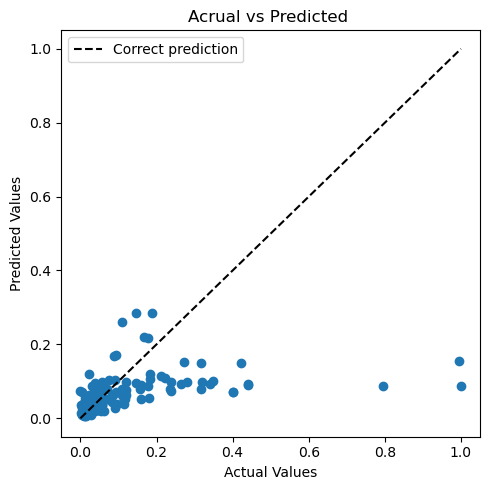

Eddited KNN
 
Tunning Part for Eddited KNN 
Best k: 2, Best Error Threshold: 0.2, Performance: 0.03458624708624709

 Eddited KNN Main Fuction

 One Example for edditing error removal
Actual value:  0.003496503496503497
Predicted value:  0.014423076923076924
Error: 0.010926573426573428
Error is greater than threshold, so removing this value from dataset


Fold: 0
Fold 0, Mean Absolute Error: 0.012628818549871182
Fold: 1
Fold 1, Mean Absolute Error: 0.012812845049687153
Fold: 2
Fold 2, Mean Absolute Error: 0.0152972027972028
Fold: 3
Fold 3, Mean Absolute Error: 0.015504232609495768
Fold: 4
Fold 4, Mean Absolute Error: 0.011179609863820389
Fold: 5
Fold 5, Mean Absolute Error: 0.013479941111520058
Fold: 6
Fold 6, Mean Absolute Error: 0.02369341185130659
Fold: 7
Fold 7, Mean Absolute Error: 0.036805299963194704
Fold: 8
Fold 8, Mean Absolute Error: 0.06355815237394186
Fold: 9
Fold 9, Mean Absolute Error: 0.26844405594405585
KNN Eddited: Average MAE across all folds: 0.04734035701140964
Kmean

In [132]:
#Main driver class calls all other classes  

class Driver:
    def __init__(self):
        self.DSNames_classification = 'glass', 'soybean-small', 'breast-cancer-wisconsin'
        self.DSNames_regression = 'abalone', 'machine', 'forestfires'
    
    def main_classification(self):
        #change the dataset number here from 0 to 2
        ds = DataSet(self.DSNames_classification[0])
        ds.type = 'Classification'
        ds_reader = Dataset_Reader()
        ds_reader.read_data_file(ds)
            
        pp = PreProcess(ds)
        pp.split_tuning_data_classification(ds)
        knn = KNN_Classification()
        pp.split_data_classification(ds)
       
        
    #Regression
    def main_regression(self):
        #change the dataset number here from 0 to 2
        ds = DataSet(self.DSNames_regression[1])
        ds.type = 'Regression'
        ds_reader = Dataset_Reader()
        ds_reader.read_data_file(ds)
        
        pp = PreProcess(ds)
        pp.split_tuning_data_regression(ds)
        pp.split_data_regression(ds)
        
        print('KNN- standard')
        knn = KNN_Regression()
        knn.tuning_k(ds)
        knn.mainFunction(ds)
        
        print('Eddited KNN')
        ke = EditedKNNRegression()
        ke.tune_k_and_threshold(ds)
        ke.mainFunction(ds)
        
        print('Kmean Clustering')
        #pass the k from edited knn to clusters
        #this class will make clusters
        kmc = KMeansClustering()
        kmc.tuning_kc(ds)
        #kmc = KMeansClustering(k=3)
        kmc.mainFunction(ds)
        #pass the centroids and values to this class
        kgr = KNN_Gaussian_Regression(centroids = kmc.centroids, centroid_values= kmc.labels, k =ke.k)
        kgr.tuning_bandwidth(ds)
        kgr.mainFunction(ds)
        
        
#calling the driver class here.    
dr = Driver()
print('\nTen Fold Demonstration')
dr.main_classification()
print('\n')
dr.main_regression()    
        

In [ ]:
#Forest Fire DataSet
#sample1: is the result of K-mean Clustering
sample01 = [1.693601485800591e-05, 1.9925523473382564e-05, 1.753379018276312e-05,
           3.3876317633102746e-06, 2.072171857836256e-05, 0.0010627057078018106,
           0.002668567316247554, 0.005658917432272502, 0.01183330488038679,0.07339555164437979
          ]
        
#sample2: is the result of Eddited KNN
sample02 = [0.005490166850875838, 0.006520172466240352, 0.00580724440121342, 
           0.006296688009455009, 0.006613248268581466, 0.006337277975510517,
           0.003992872412519772, 0.00524353277293915, 0.007642246013238997, 0.07076117742044265
          ]
#sample 3 is the result of standard KNN
sample03 = [0.013927713588399985, 0.013628125542312597, 0.008772664483666273,
           0.01215639936156414, 0.009550144921636047, 0.013768467315543821, 
           0.009013802391241747,0.005546416670753066, 0.009929662903456302,0.07068575698088851
          ]
#Machine Dataset
#sample4: is the result of K-mean Clustering
sample4 = [0.005888847994111152, 0.012697828487302174, 0.01900073610599926,
           0.02438351122561649, 0.03248067721751933, 0.041589988958410005,
           0.05589804931910195, 0.09334744203165256, 0.1570666175929334,0.410270979020979]
        
#sample5: is the result of Eddited KNN
sample5 = [0.012628818549871182, 0.012812845049687153, 0.0152972027972028, 
           0.015504232609495768, 0.011179609863820389, 0.013479941111520058,
           0.02369341185130659, 0.036805299963194704, 0.06355815237394186, 0.26844405594405585
          ]
#sample6 is the result of standard KNN
sample6 = [0.021931855236135212, 0.014265789834096581, 0.01815893178565802,
           0.015168014756375888, 0.01655871712860518, 0.013963896370141145, 
           0.019511610106673523,0.046585666739504566, 0.07457553008338273,0.3097458766545037
          ]

#Abalone Dataset
#sample7: is the result of K-mean Clustering
sample7 = [0.3424158838481524, 0.2887105735386065, 0.2503090781734497,
           0.2283028365757166, 0.21542446064982448, 0.18100929700661064,
           0.16394339537095778, 0.13429465683713254, 0.07687529605393084,0.0786549492199398
          ]
        
#sample8: is the result of Eddited KNN
sample8 = [0.058263677811550174, 0.04523176291793312, 0.04416793313069908, 
           0.04428191489361702, 0.04148936170212766, 0.040463525835866265,
           0.04141337386018237, 0.051462765957446824, 0.09057750759878419, 0.2096362954630671
          ]
#sample9 is the result of standard KNN
sample9 = [0.06352171750527556, 0.04673897251447117, 0.049430548728637405,
           0.050182907975997344, 0.046138741194388204, 0.0446938496523912, 
           0.04151049556938836,0.046943298498270794, 0.07354661352087384,0.2097285526418535
          ]


In [30]:
#Now once we have results, we will apply statistcal tests on it.
#to prove if the hypothesis

def statistical_test():
        import scipy.stats as stats  # Import necessary statistical module
        
        # Perform the Shapiro-Wilk test for normality on both sets of samples
        shapiro_statistic, p_value = stats.shapiro(sample1)
        shapiro_statistic, p_value2 = stats.shapiro(sample2)

        # Output the results of the Shapiro-Wilk test
        print(f"Shapiro-Wilk Test Statistic: {shapiro_statistic}")
        print(f"P-value: {p_value}")

        # If both samples are normally distributed (p > 0.05), proceed with a paired t-test
        if p_value > 0.05 and p_value2 > 0.05:
            print("The differences are normally distributed.")

            # Perform a paired t-test to compare the two sets of samples
            t_statistic, t_p_value = stats.ttest_rel(sample1, sample2)

            # Output the result of the t-test
            print(f'Paired t-test p-value: {t_p_value}')

            # Check if the p-value is below 0.05, indicating a statistically significant difference
            if t_p_value < 0.05:
                print("The two models are significantly different.")
            else:
                print("The two models are not significantly different.")
        else:
            # If the samples are not normally distributed, perform a non-parametric Wilcoxon signed-rank test
            print("The differences are not normally distributed.")

            # Perform the Wilcoxon signed-rank test to compare the two sets of samples
            wilcoxon_statistic, wilcoxon_p_value = stats.wilcoxon(sample1, sample2)

            # Output the result of the Wilcoxon test
            print(f'Wilcoxon signed-rank test p-value: {wilcoxon_p_value}')
            print(f'Wilcoxon Test statistic: {wilcoxon_statistic}, P-value: {wilcoxon_p_value}')

            # Check if the p-value is below 0.05, indicating a statistically significant difference
            if wilcoxon_p_value < 0.05:
                print("The two models are significantly different.")
            else:
                print("The two models are not significantly different.")
              


In [28]:
#this is to test the difference of eddited and k mean clustering results
#for each dataset

list_samples = [sample01, sample02, sample4, sample5, sample7, sample8 ]
i = 0
while i < len(list_samples):  
    print(i)
    sample1 = list_samples[i]  
    sample2 = list_samples[i + 1]  
    
    i += 2
    # Call the statistical test with the two consecutive samples
    statistical_test()

0
Shapiro-Wilk Test Statistic: 0.410786509513855
P-value: 2.394991497567389e-06
The differences are not normally distributed.
Wilcoxon signed-rank test p-value: 0.048828125
Wilcoxon Test statistic: 8.0, P-value: 0.048828125
The two models are significantly different.
2
Shapiro-Wilk Test Statistic: 0.5141381025314331
P-value: 0.00028908593230880797
The differences are not normally distributed.
Wilcoxon signed-rank test p-value: 0.013671875
Wilcoxon Test statistic: 4.0, P-value: 0.013671875
The two models are significantly different.
4
Shapiro-Wilk Test Statistic: 0.5605525970458984
P-value: 0.8808746933937073
The differences are not normally distributed.
Wilcoxon signed-rank test p-value: 0.01953125
Wilcoxon Test statistic: 5.0, P-value: 0.01953125
The two models are significantly different.


In [29]:
#Next we will test the standard with eddited  

list_samples = [sample03, sample02, sample6, sample5, sample9, sample8 ]
i = 0
while i < len(list_samples):  
    print(i)
    sample1 = list_samples[i]  
    sample2 = list_samples[i + 1]  
    
    i += 2
    # Call the statistical test with the two consecutive samples
    statistical_test()

0
Shapiro-Wilk Test Statistic: 0.410786509513855
P-value: 3.712407988132327e-06
The differences are not normally distributed.
Wilcoxon signed-rank test p-value: 0.00390625
Wilcoxon Test statistic: 1.0, P-value: 0.00390625
The two models are significantly different.
2
Shapiro-Wilk Test Statistic: 0.5141381025314331
P-value: 5.332392447598977e-06
The differences are not normally distributed.
Wilcoxon signed-rank test p-value: 0.02734375
Wilcoxon Test statistic: 6.0, P-value: 0.02734375
The two models are significantly different.
4
Shapiro-Wilk Test Statistic: 0.5605525970458984
P-value: 6.105638476583408e-06
The differences are not normally distributed.
Wilcoxon signed-rank test p-value: 0.232421875
Wilcoxon Test statistic: 15.0, P-value: 0.232421875
The two models are not significantly different.


In [31]:
# This will test the standard with k mean clustering  

list_samples = [sample03, sample01, sample6, sample4, sample9, sample7 ]
i = 0
while i < len(list_samples):  
    print(i)
    sample1 = list_samples[i]  
    sample2 = list_samples[i + 1]  
    
    i += 2
    # Call the statistical test with the two consecutive samples
    statistical_test()

0
Shapiro-Wilk Test Statistic: 0.4845079779624939
P-value: 3.712407988132327e-06
The differences are not normally distributed.
Wilcoxon signed-rank test p-value: 0.02734375
Wilcoxon Test statistic: 6.0, P-value: 0.02734375
The two models are significantly different.
2
Shapiro-Wilk Test Statistic: 0.6599441766738892
P-value: 5.332392447598977e-06
The differences are not normally distributed.
Wilcoxon signed-rank test p-value: 0.037109375
Wilcoxon Test statistic: 7.0, P-value: 0.037109375
The two models are significantly different.
4
Shapiro-Wilk Test Statistic: 0.9689428806304932
P-value: 6.105638476583408e-06
The differences are not normally distributed.
Wilcoxon signed-rank test p-value: 0.013671875
Wilcoxon Test statistic: 4.0, P-value: 0.013671875
The two models are significantly different.
